In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import mannwhitneyu
import statsmodels.api as sm
from statsmodels.formula.api import ols
import gsw
from datetime import datetime
from scipy.stats import t

In [2]:
sns.set_context("talk",
               #font_scale = 1.5,
               rc = {"lines.linewidth":2.5})
params = {"ytick.color" : "k",
          "xtick.color" : "k",
          "axes.labelcolor" : "k",
          "axes.edgecolor" : "k",
         "text.color":"k"}
plt.rcParams.update(params)

In [3]:
stationdict = {"highnitrite":np.arange(1,30),
               "lownitrite":np.arange(30,72),
               "highpoc":np.arange(20,28),
               "lowpochighnitrite":np.concatenate((np.arange(1,20), np.arange(28,30))),
               "lowpoclownitrite":np.arange(30,72)}  # in sigma0

In [4]:
data = pd.read_csv("5906484qcno2_updated.txt",skiprows = 79, sep='\t',
    parse_dates = ['mon/day/yr'], na_values = [-10000000000.0])

data.rename(columns={
    'Lon [°E]': 'lon',
    'Lat [°N]': 'lat',
    'Pressure[dbar]':'pres',
    'Temperature[°C]': 'temp',
    'Salinity[pss]': 'psal',
    'Oxygen[µmol/kg]': 'doxy'}, inplace=True)


data['gtime'] = pd.to_datetime(
    data['mon/day/yr'].astype(str) + ' ' + data['hh:mm'].astype(str),
    format="%Y-%m-%d %H:%M"
    )

def to_decimal_year(dt):
    year_start = datetime(dt.year, 1, 1)
    year_end = datetime(dt.year + 1, 1, 1)
    return dt.year + ((dt - year_start).total_seconds() / (year_end - year_start).total_seconds())

data['gtime'] = data['gtime'].apply(to_decimal_year)
data

,Cruise,Station,Type,mon/day/yr,hh:mm,lon,lat,QF,IceEvRec,pres,...,QF.14,DIC_LIAR[µmol/kg],QF.15,pCO2_LIAR[µatm],QF.16,Nitrite[µmol/kg],QF.17,S2O3[µmol/kg],QF.18,gtime
0,5906484,1,C,2022-01-15,18:25,252.269,17.021,0,0,1798.72,...,0.0,2371.0,0.0,808.1,0.0,0.0,0,0.0,0,2022.040459
1,5906484,1,C,2022-01-15,18:25,252.269,17.021,0,0,1699.33,...,0.0,2372.0,0.0,842.1,0.0,0.0,0,0.0,0,2022.040459
2,5906484,1,C,2022-01-15,18:25,252.269,17.021,0,0,1599.74,...,0.0,2373.0,0.0,885.2,0.0,0.0,0,0.0,0,2022.040459
3,5906484,1,C,2022-01-15,18:25,252.269,17.021,0,0,1499.78,...,0.0,2373.0,0.0,935.1,0.0,0.0,0,0.0,0,2022.040459
4,5906484,1,C,2022-01-15,18:25,252.269,17.021,0,0,1400.29,...,0.0,2374.0,0.0,984.3,0.0,0.0,0,0.0,0,2022.040459
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6869,5906484,97,C,2024-10-06,06:28,248.709,15.920,0,0,21.88,...,0.0,1970.0,0.0,477.3,0.0,0.0,0,0.0,0,2024.763031
6870,5906484,97,C,2024-10-06,06:28,248.709,15.920,0,0,16.88,...,0.0,1964.0,0.0,473.1,0.0,0.0,0,0.0,0,2024.763031
6871,5906484,97,C,2024-10-06,06:28,248.709,15.920,0,0,11.42,...,0.0,1962.0,0.0,471.8,0.0,0.0,0,0.0,0,2024.763031
6872,5906484,97,C,2024-10-06,06:28,248.709,15.920,0,0,7.42,...,0.0,1960.0,0.0,470.8,0.0,0.0,0,0.0,0,2024.763031


In [5]:
data.columns

Index(['Cruise', 'Station', 'Type', 'mon/day/yr', 'hh:mm', 'lon', 'lat', 'QF',
       'IceEvRec', 'pres', 'QF.1', 'temp', 'QF.2', 'psal', 'QF.3',
       'Sigma_theta[kg/m^3]', 'QF.4', 'Depth[m]', 'QF.5', 'doxy', 'QF.6',
       'OxygenSat[%]', 'QF.7', 'Nitrate[µmol/kg]', 'QF.8', 'Chl_a[mg/m^3]',
       'QF.9', 'b_bp700[1/m]', 'QF.10', 'POC[mmol/m^3]', 'QF.11',
       'pHinsitu[Total]', 'QF.12', 'pH25C[Total]', 'QF.13',
       'TALK_LIAR[µmol/kg]', 'QF.14', 'DIC_LIAR[µmol/kg]', 'QF.15',
       'pCO2_LIAR[µatm]', 'QF.16', 'Nitrite[µmol/kg]', 'QF.17',
       'S2O3[µmol/kg]', 'QF.18', 'gtime'],
      dtype='object')

In [7]:
data[np.isin(data.Station, stationdict["lowpochighnitrite"])]['Station'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 28, 29])

In [8]:
data = pd.read_csv("data_clean.csv")
data[np.isin(data.Station, stationdict["lowpochighnitrite"])].Date.unique()

array(['2022-01-15', '2022-01-26', '2022-02-05', '2022-02-15',
       '2022-02-26', '2022-03-08', '2022-03-18', '2022-03-29',
       '2022-04-08', '2022-04-18', '2022-04-29', '2022-05-09',
       '2022-05-19', '2022-05-30', '2022-06-09', '2022-06-19',
       '2022-06-29', '2022-07-10', '2022-07-20', '2022-10-21',
       '2022-11-01'], dtype=object)

In [33]:
# Load Data
data = pd.read_csv("data_clean.csv")
data = data[
    [
        "Station",
        "Depth",
        "lon",
        "lat",
        "T",
        "S",
        "P",
        "O2",
        "sigma0",
        "rho",
        "DIC",
        "DIP",
        "NO3",
        "NO2"
    ]
]

data = data[(data.Station != 47)&
           (data.Station != 58)]

# Calculate AOU
SA = gsw.SA_from_SP(data["S"], data["P"], data["lon"], data["lat"])
PT = gsw.pt0_from_t(SA, data["T"], data["P"])
O2sat = gsw.O2sol_SP_pt(data["S"], PT)
AOU = O2sat - data["O2"]
data["AOU"] = AOU
data["DIN"] = data["NO3"] + data["NO2"]

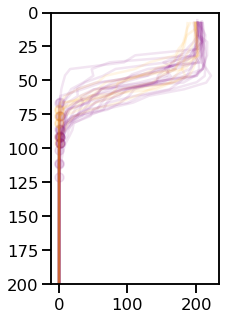

In [34]:
stationlistlow = stationdict["lowpochighnitrite"]
stationlisthigh = stationdict["highpoc"]

upperinterfacedepths = []
lowerinterfacedepths = []
upperinterfacesigmas = []
lowerinterfacesigmas = []

fig, ax = plt.subplots(1,1, figsize = (3,5))
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        int1 = stationdata[stationdata.O2 < 2].sort_values('Depth').iloc[0]
        int2 = stationdata[stationdata.O2 < 2].sort_values('Depth').iloc[-1]
        upperinterfacedepths.append(int1.Depth)
        lowerinterfacedepths.append(int2.Depth)
        upperinterfacesigmas.append(int1.sigma0)
        lowerinterfacesigmas.append(int2.sigma0)
        ax.plot(np.array(stationdata.O2), np.array(stationdata.Depth),
                color = "purple", label = "low nitrite", alpha = 0.1)
        ax.scatter(int1.O2, int1.Depth, color = "purple", label = "low nitrite", alpha = 0.1)
        ax.scatter(int2.O2, int2.Depth, color = "purple", label = "low nitrite", alpha = 0.1)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        int1 = stationdata[stationdata.O2 < 2].sort_values('Depth').iloc[0]
        int2 = stationdata[stationdata.O2 < 2].sort_values('Depth').iloc[-1]
        upperinterfacedepths.append(int1.Depth)
        lowerinterfacedepths.append(int2.Depth)
        upperinterfacesigmas.append(int1.sigma0)
        lowerinterfacesigmas.append(int2.sigma0)
        ax.plot(np.array(stationdata.O2), np.array(stationdata.Depth),
                color = "orange", label = "high nitrite", alpha = 0.1)
        ax.scatter(int1.O2, int1.Depth, color = "orange", label = "high nitrite", alpha = 0.1)
        ax.scatter(int2.O2, int2.Depth, color = "orange", label = "high nitrite", alpha = 0.1)

ax.set_ylim([200,0])

upperinterfacedepth = np.mean(upperinterfacedepths)
lowerinterfacedepth = np.mean(lowerinterfacedepths)
upperinterfacesigma = np.mean(upperinterfacesigmas)
lowerinterfacesigma = np.mean(lowerinterfacesigmas)

In [35]:
columndict = {"# DNRN":"DNRN",
        " Anammox":"anammox",
        " Denitrification":"denitrification",
        " Nitrite Oxidation":"nitrox",
        " CaCO3 Dissolution ":"caco3diss"}

chunklow = "lowpochighnitrite"
chunkhigh = "highpoc"
layer = 1
param = "DNRN"
labellow = f"{chunklow}\nlayer {layer}"
labelhigh = f"{chunkhigh}\nlayer {layer}"

slopeslow = pd.read_excel(f"output/chunk{chunklow}/slopesDF.xlsx")
slopeshigh = pd.read_excel(f"output/chunk{chunkhigh}/slopesDF.xlsx")

In [36]:
pvals = np.ones(slopeslow.shape[0])

for layer in list(slopeslow.index):
    slope1 = slopeslow.iloc[layer].NstarvsDICslope
    se1 = slopeslow.iloc[layer].NstarvsDICerr
    n1 = slopeslow.iloc[layer].n
    k1 = 2
    
    slope2 = slopeshigh.iloc[layer].NstarvsDICslope
    se2 = slopeshigh.iloc[layer].NstarvsDICerr
    n2 = slopeshigh.iloc[layer].n
    k2 = 2
    
    # Test statistic
    t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
    
    # Degrees of freedom (Welch–Satterthwaite)
    numerator = (se1**2 + se2**2)**2
    denominator = (se1**4)/(n1 - k1) + (se2**4)/(n2 - k2)
    df = numerator / denominator
    
    # Two-tailed p-value
    p = 2 * (1 - t.cdf(abs(t_stat), df))
    pvals[layer] = p
    
    print(f"t = {t_stat:.3f}, df = {df:.1f}, p = {p:.4f}")

idx_sig = np.where(pvals <= 0.001)

t = 3.305, df = 12.5, p = 0.0060
t = 0.970, df = 18.1, p = 0.3451
t = 0.443, df = 28.3, p = 0.6610
t = 2.303, df = 48.9, p = 0.0256
t = 0.381, df = 51.7, p = 0.7048
t = -0.240, df = 38.7, p = 0.8115
t = -2.844, df = 141.4, p = 0.0051
t = 0.507, df = 85.6, p = 0.6135


In [37]:
idx_sig

(array([], dtype=int64),)

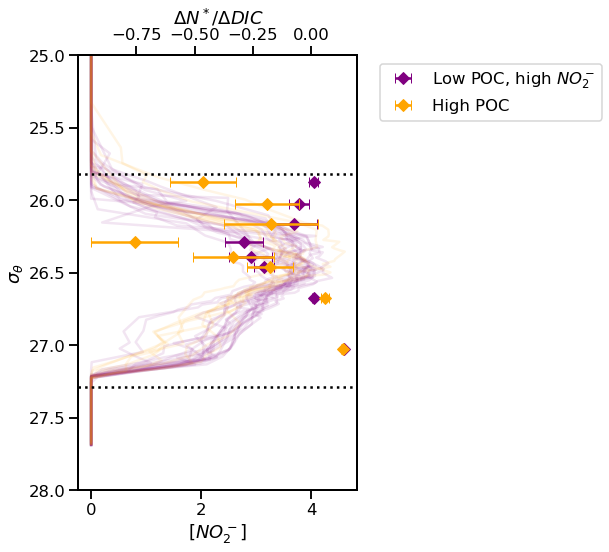

In [38]:
stationlistlow = stationdict["lowpochighnitrite"]
stationlisthigh = stationdict["highpoc"]

chunklow = "lowpochighnitrite"
chunkhigh = "highpoc"

fig, ax = plt.subplots(1,1, figsize = (5,8))
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "purple", label = None, alpha = 0.1, zorder = 0)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "orange", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([28,25])
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()
ax2.errorbar(slopeslow.NstarvsDICslope, slopeslow.sigma0,
            xerr = slopeslow.NstarvsDICerr, label = r"Low POC, high $NO_2^-$", color = "purple",
           marker = "D", linestyle = "none", capsize = 5, zorder = 1)
ax2.errorbar(slopeshigh.NstarvsDICslope, slopeshigh.sigma0,
            xerr = slopeshigh.NstarvsDICerr, label = r"High POC", color = "orange",
           marker = "D", linestyle = "none", capsize = 5, zorder = 2)

ax2.scatter(slopeshigh.NstarvsDICslope.iloc[idx_sig] + slopeslow.NstarvsDICerr.iloc[idx_sig] + 0.1,
            slopeshigh.sigma0.iloc[idx_sig], marker = "*", color = "k")

ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([28,25])
ax2.set_xlabel(r"$\Delta N^*/\Delta DIC$")
ax.set_ylabel(r"$\sigma_{\theta}$")

ax2.axhline(upperinterfacesigma, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacesigma, color = "k", linestyle = ":")

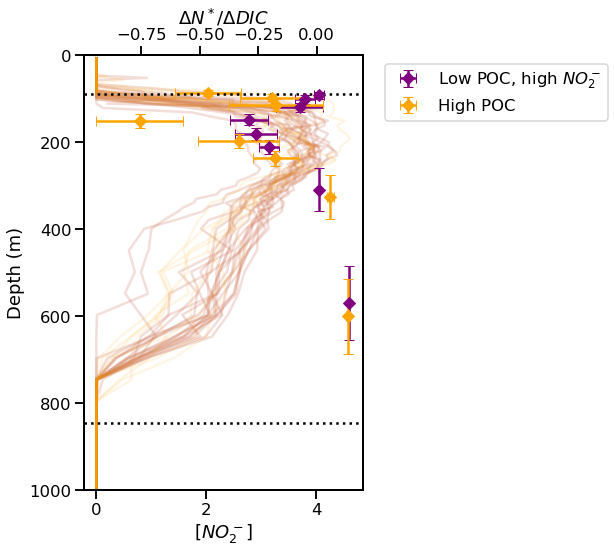

In [39]:
stationlistlow = stationdict["lowpochighnitrite"]
stationlisthigh = stationdict["highnitrite"]

chunk1 = "lowpochighnitrite"
chunk2 = "highnitrite"

fig, ax = plt.subplots(1,1, figsize = (5,8))
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "purple", label = None, alpha = 0.1)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "orange", label = None, alpha = 0.1)
ax.set_ylim([1000,0])
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()
ax2.errorbar(slopeslow.NstarvsDICslope, slopeslow.depth,
            xerr = slopeslow.NstarvsDICerr, yerr = slopeslow.deptherr, label = r"Low POC, high $NO_2^-$", color = "purple",
           marker = "D", linestyle = "none", capsize = 5)
ax2.errorbar(slopeshigh.NstarvsDICslope, slopeshigh.depth,
            xerr = slopeshigh.NstarvsDICerr, yerr = slopeshigh.deptherr, label = r"High POC", color = "orange",
           marker = "D", linestyle = "none", capsize = 5)

ax2.scatter(slopeshigh.NstarvsDICslope.iloc[idx_sig] + slopeslow.NstarvsDICerr.iloc[idx_sig] + 0.1,
            slopeshigh.depth.iloc[idx_sig], marker = "*", color = "k")


ax2.legend(bbox_to_anchor = (1.05, 1.0))
ax2.set_ylim([1000,0])
ax2.set_xlabel(r"$\Delta N^*/\Delta DIC$")
ax.set_ylabel(r"Depth (m)")

ax2.axhline(upperinterfacedepth, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacedepth, color = "k", linestyle = ":")

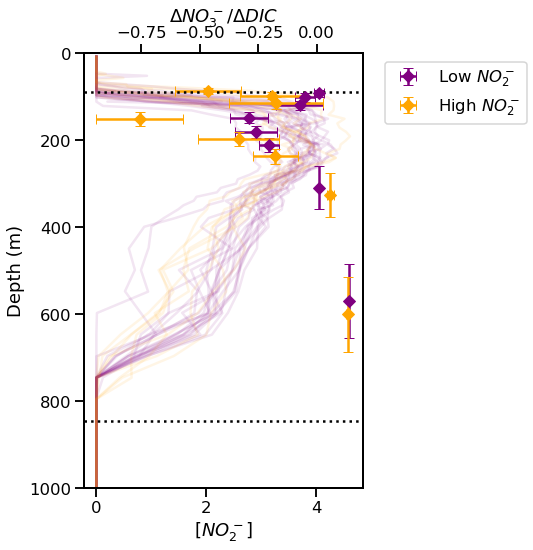

In [40]:
stationlistlow = stationdict["lowpochighnitrite"]
stationlisthigh = stationdict["highpoc"]

chunk1 = "lowpochighnitrite"
chunk2 = "highpoc"

fig, ax = plt.subplots(1,1, figsize = (5,8))
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "purple", label = None, alpha = 0.1)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "orange", label = None, alpha = 0.1)
ax.set_ylim([1000,0])
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()
ax2.errorbar(slopeslow.NstarvsDICslope, slopeslow.depth,
            xerr = slopeslow.NstarvsDICerr, yerr = slopeslow.deptherr, label = r"Low $NO_2^-$", color = "purple",
           marker = "D", linestyle = "none", capsize = 5)
ax2.errorbar(slopeshigh.NstarvsDICslope, slopeshigh.depth,
            xerr = slopeshigh.NstarvsDICerr, yerr = slopeshigh.deptherr, label = r"High $NO_2^-$", color = "orange",
           marker = "D", linestyle = "none", capsize = 5)

ax2.scatter(slopeshigh.NstarvsDICslope.iloc[idx_sig] + slopeslow.NstarvsDICerr.iloc[idx_sig] + 0.1,
            slopeshigh.depth.iloc[idx_sig], marker = "*", color = "k")


ax2.legend(bbox_to_anchor = (1.05, 1.0))
ax2.set_ylim([1000,0])
ax2.set_xlabel(r"$\Delta NO_3^-/\Delta DIC$")
ax.set_ylabel(r"Depth (m)")

ax2.axhline(upperinterfacedepth, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacedepth, color = "k", linestyle = ":")

In [41]:
slope1 = slopeslow.iloc[layer].NstarvsDICslope
se1 = slopeslow.iloc[layer].NstarvsDICerr
n1 = slopeslow.iloc[layer].n
k1 = 2

slope2 = slopeshigh.iloc[layer].NstarvsDICslope
se2 = slopeshigh.iloc[layer].NstarvsDICerr
n2 = slopeshigh.iloc[layer].n
k2 = 2

# Test statistic
t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)

# Degrees of freedom (Welch–Satterthwaite)
numerator = (se1**2 + se2**2)**2
denominator = (se1**4)/(n1 - k1) + (se2**4)/(n2 - k2)
df = numerator / denominator

# Two-tailed p-value
p = 2 * (1 - t.cdf(abs(t_stat), df))

print(f"t = {t_stat:.3f}, df = {df:.1f}, p = {p:.4f}")

t = 0.507, df = 85.6, p = 0.6135


In [42]:
from scipy.stats import ttest_ind, ttest_ind_from_stats

# Compute the descriptive statistics of a and b.
abar = slopeslow.iloc[layer].NstarvsDICslope
avar = slopeslow.iloc[layer].NstarvsDICerr #sample1.var(ddof=1)
na = slopeslow.iloc[layer].n
adof = na - 1

bbar = slopeshigh.iloc[layer].NstarvsDICslope
bvar = slopeshigh.iloc[layer].NstarvsDICerr #sample2.var(ddof=1)
nb = slopeshigh.iloc[layer].n
bdof = nb - 1

# Use scipy.stats.ttest_ind_from_stats.
t2, p2 = ttest_ind_from_stats(abar, avar * np.sqrt(na), na,
                              bbar, bvar * np.sqrt(nb), nb,
                              equal_var=False)
print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))

ttest_ind_from_stats: t = 0.507006  p = 0.613427


In [43]:
stationdict

{'highnitrite': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 'lownitrite': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71]),
 'highpoc': array([20, 21, 22, 23, 24, 25, 26, 27]),
 'lowpochighnitrite': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 28, 29]),
 'lowpoclownitrite': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71])}

In [44]:
?np.permutations

Object `np.permutations` not found.


In [45]:
def test_significance(chunk1, chunk2, param=None, columndict=None, alpha = 0.001):
    slopes1 = pd.read_excel(f"output/chunk{chunk1}/slopesDF.xlsx")
    slopes2 = pd.read_excel(f"output/chunk{chunk2}/slopesDF.xlsx")
    
    pvals = np.ones(slopes1.shape[0])
    outputvals = np.ones((slopes1.shape[0],4))

    for layer in list(slopes1.index):

        df1 = pd.read_csv(f"output/chunk{chunk1}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
        df2 = pd.read_csv(f"output/chunk{chunk2}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
        
        slope1 = df1[param].mean()
        n1 = slopes1.iloc[layer].n
        se1 = df1[param].std() / np.sqrt(n1)
        k1 = 2
        
        slope2 = df2[param].mean()
        n2 = slopes2.iloc[layer].n
        se2 = df2[param].std() / np.sqrt(n2)
        k2 = 2
        
        # Test statistic
        t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
        
        # Degrees of freedom (Welch–Satterthwaite)
        numerator = (se1**2 + se2**2)**2
        denominator = (se1**4)/(n1 - k1) + (se2**4)/(n2 - k2)
        df = numerator / denominator
        
        # Two-tailed p-value
        p = 2 * (1 - t.cdf(abs(t_stat), df))
        
        pvals[layer] = p
        outputvals[layer,:] = np.array([slope1, df1[param].std(), slope2, df2[param].std()])
        
        #print(f"t = {t_stat:.3f}, df = {df:.1f}, p = {p:.4f}")
    
    idx_sig = np.where(pvals <= alpha)

    return pvals, outputvals, idx_sig

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623160.py:24: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623160.py:29: RuntimeWarning: invalid value encountered in scalar divide
  df = numerator / denominator
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623160.py:24: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623160.py:29: RuntimeWarning: invalid value encountered in scalar divide
  df = numerator / denominator
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623160.py:24: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623

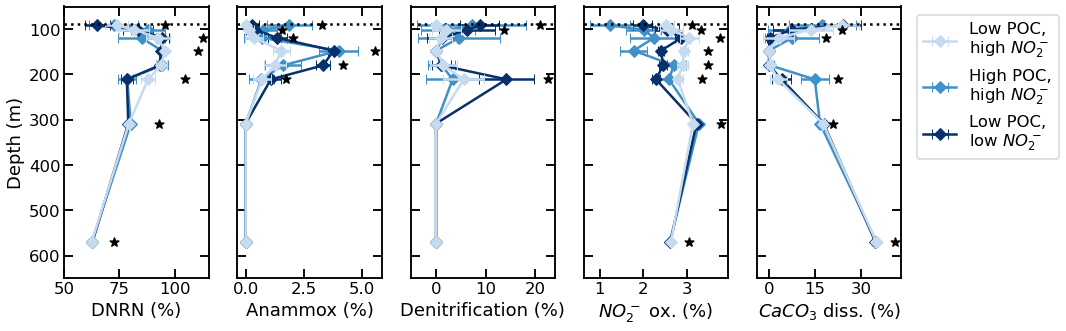

In [46]:
cmap = plt.get_cmap('Blues')
[color1, color2, color3] = cmap(np.linspace(0.25, 1, 3))

yparam = "Depth"

chunk1 = "lowpochighnitrite"
chunk2 = "highpoc"
chunk3 = "lowpoclownitrite"

label1 = "Low POC,\nhigh $NO_2^-$"
label2 = "High POC,\nhigh $NO_2^-$"
label3 = "Low POC,\nlow $NO_2^-$"

stationlist1 = stationdict["lowpochighnitrite"]
stationlist2 = stationdict["highpoc"]
stationlist3 = stationdict["lowpoclownitrite"]

slopes1 = pd.read_excel(f"output/chunk{chunk1}/slopesDF.xlsx")
slopes2 = pd.read_excel(f"output/chunk{chunk2}/slopesDF.xlsx")
slopes3 = pd.read_excel(f"output/chunk{chunk3}/slopesDF.xlsx")

columndict = {"# DNRN":"DNRN",
        " Anammox":"anammox",
        " Denitrification":"denitrification",
        " Nitrite Oxidation":"nitrox",
        " CaCO3 Dissolution ":"caco3diss"}

xlabels = ["DNRN", "Anammox", "Denitrification", "$NO_2^-$ ox.", "$CaCO_3$ diss."]
xticklist = [
    [50,75,100],
    [0,2.5,5],
    [0,10,20],
    [1,2,3],
    [0,15,30]
]

fig, axes = plt.subplots(1,5, figsize = (15,5), sharey=True)

for i, param in enumerate(["DNRN", "anammox", "denitrification", "nitrox", "caco3diss"]):

    pvals1v2, outputvals1v2, idx_sig1v2 = test_significance(chunk1, chunk2, param=param, columndict=columndict)
    pvals1v3, outputvals1v3, idx_sig1v3 = test_significance(chunk1, chunk3, param=param, columndict=columndict)
    pvals2v3, outputvals2v3, idx_sig2v3 = test_significance(chunk2, chunk3, param=param, columndict=columndict)

    ax = axes[i]
    
    ax.errorbar(outputvals1v2[:,0]*100, slopes1.depth,
                xerr = outputvals1v2[:,1]*100, label = label1,
                 color = color1,
               marker = "D", capsize = 5, zorder = 2)
    ax.errorbar(outputvals1v2[:,2]*100, slopes1.depth,
                xerr = outputvals1v2[:,3]*100, label = label2,
                 color =  color2,
               marker = "D", capsize = 5, zorder = 1)
    ax.errorbar(outputvals1v3[:,2]*100, slopes1.depth,
                xerr = outputvals1v3[:,3]*100, label = label3,
                 color =  color3,
               marker = "D", capsize = 5, zorder = 1)
    
    idx_sig = [idx for idx in range(len(pvals2v3)) if (idx in idx_sig1v2[0]) | (idx in idx_sig2v3[0]) | (idx in idx_sig1v3[0])]
    maxvals = np.array([np.max([outputvals1v2[layer,0]+outputvals1v2[layer,1],
        outputvals1v2[layer,2]+outputvals1v2[layer,3],
        outputvals1v3[layer,2]+outputvals1v3[layer,3]]) for layer in range(len(pvals2v3))])

    ax.scatter(maxvals[idx_sig]*100*1.15,
                slopes1.depth.iloc[idx_sig], marker = "*", color = "k", zorder = 3)
    
    ax.set_ylim([650,50])
    
    ax.axhline(upperinterfacedepth, color = "k", linestyle = ":")
    ax.axhline(lowerinterfacedepth, color = "k", linestyle = ":")
    ax.set_xlabel(f"{xlabels[i]} (%)")
    ax.set_xticks(xticklist[i])
    ax.tick_params(top=True, right=True, direction = "in")
'''
ax2 = axes[0].twiny()

for count, stationlist in enumerate([stationlist1, stationlist2, stationlist3]):
    for s in stationlist:
        stationdata = data[data.Station == s].sort_values(yparam)
        if len(stationdata) > 0:
            ax2.plot(np.array(stationdata.NO2), np.array(stationdata[yparam]),
                    color = colors[count], label = None, alpha = 0.1, 
                    zorder = 0)

ax2.set_ylim([650,50])
ax2.set_ylabel(r"Depth (m)")
ax2.set_xlabel(r"[$NO_2^-$]")
'''
axes[0].set_ylabel("Depth (m)")
axes[-1].legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
plt.savefig('figures/alldepthprofiles.pdf', bbox_inches = "tight")

/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623160.py:24: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623160.py:29: RuntimeWarning: invalid value encountered in scalar divide
  df = numerator / denominator
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623160.py:24: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623160.py:29: RuntimeWarning: invalid value encountered in scalar divide
  df = numerator / denominator
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623160.py:24: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_8357/848623

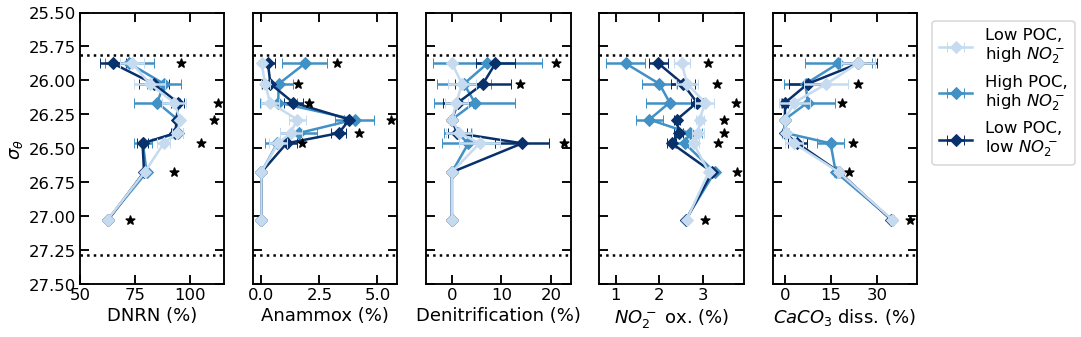

In [28]:
yparam = "sigma0"

chunk1 = "lowpochighnitrite"
chunk2 = "highpoc"
chunk3 = "lowpoclownitrite"

label1 = "Low POC,\nhigh $NO_2^-$"
label2 = "High POC,\nhigh $NO_2^-$"
label3 = "Low POC,\nlow $NO_2^-$"

stationlist1 = stationdict["lowpochighnitrite"]
stationlist2 = stationdict["highpoc"]
stationlist3 = stationdict["lowpoclownitrite"]

slopes1 = pd.read_excel(f"output/chunk{chunk1}/slopesDF.xlsx")
slopes2 = pd.read_excel(f"output/chunk{chunk2}/slopesDF.xlsx")
slopes3 = pd.read_excel(f"output/chunk{chunk3}/slopesDF.xlsx")

columndict = {"# DNRN":"DNRN",
        " Anammox":"anammox",
        " Denitrification":"denitrification",
        " Nitrite Oxidation":"nitrox",
        " CaCO3 Dissolution ":"caco3diss"}

fig, axes = plt.subplots(1,5, figsize = (15,5), sharey=True)
xlabels = ["DNRN", "Anammox", "Denitrification", "$NO_2^-$ ox.", "$CaCO_3$ diss."]
for i, param in enumerate(["DNRN", "anammox", "denitrification", "nitrox", "caco3diss"]):

    pvals1v2, outputvals1v2, idx_sig1v2 = test_significance(chunk1, chunk2, param=param, columndict=columndict)
    pvals1v3, outputvals1v3, idx_sig1v3 = test_significance(chunk1, chunk3, param=param, columndict=columndict)
    pvals2v3, outputvals2v3, idx_sig2v3 = test_significance(chunk2, chunk3, param=param, columndict=columndict)

    ax = axes[i]
    
    ax.errorbar(outputvals1v2[:,0]*100, slopes1.sigma0,
                xerr = outputvals1v2[:,1]*100, label = label1,
                 color = color1,
               marker = "D", capsize = 5, zorder = 2)
    ax.errorbar(outputvals1v2[:,2]*100, slopes1.sigma0,
                xerr = outputvals1v2[:,3]*100, label = label2,
                 color =  color2,
               marker = "D", capsize = 5, zorder = 1)
    ax.errorbar(outputvals1v3[:,2]*100, slopes1.sigma0,
                xerr = outputvals1v3[:,3]*100, label = label3,
                 color =  color3,
               marker = "D", capsize = 5, zorder = 1)
    
    idx_sig = [idx for idx in range(len(pvals1v2)) if (idx in idx_sig1v2[0]) | (idx in idx_sig2v3[0]) | (idx in idx_sig1v3[0])]
    maxvals = np.array([np.max([outputvals1v2[layer,0]+outputvals1v2[layer,1],
        outputvals1v2[layer,2]+outputvals1v2[layer,3],
        outputvals1v3[layer,2]+outputvals1v3[layer,3]]) for layer in range(len(pvals1v2))])

    ax.scatter(maxvals[idx_sig]*100*1.15,
                slopes1.sigma0.iloc[idx_sig], marker = "*", color = "k", zorder = 3)
    
    ax.set_ylim([27.5,25.5])
    
    ax.axhline(upperinterfacesigma, color = "k", linestyle = ":")
    ax.axhline(lowerinterfacesigma, color = "k", linestyle = ":")
    ax.set_xlabel(f"{xlabels[i]} (%)")
    ax.set_xticks(xticklist[i])
    ax.tick_params(top=True, right=True, direction = "in")
'''
ax2 = axes[0].twiny()

for count, stationlist in enumerate([stationlist1, stationlist2, stationlist3]):
    for s in stationlist:
        stationdata = data[data.Station == s].sort_values(yparam)
        if len(stationdata) > 0:
            ax2.plot(np.array(stationdata.NO2), np.array(stationdata[yparam]),
                    color = colors[count], label = None, alpha = 0.1, 
                    zorder = 0)

ax2.set_ylim([650,50])
ax2.set_ylabel(r"Depth (m)")
ax2.set_xlabel(r"[$NO_2^-$]")
'''
axes[0].set_ylabel(r"$\sigma_{\theta}$")
axes[-1].legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
plt.savefig('figures/allsigmaprofiles.pdf', bbox_inches = "tight")

In [29]:
stationdict

{'highnitrite': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]),
 'lownitrite': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71]),
 'highpoc': array([20, 21, 22, 23, 24, 25, 26, 27]),
 'lowpochighnitrite': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
        18, 19, 28, 29]),
 'lowpoclownitrite': array([30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46,
        47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63,
        64, 65, 66, 67, 68, 69, 70, 71])}

In [33]:
stationlistlow = stationdict["lowpoclownitrite"]
stationlisthigh = stationdict["highpoc"]

chunklow = "lowpoclownitrite"
chunkhigh = "highpoc"

columndict = {"# DNRN":"DNRN",
        " Anammox":"anammox",
        " Denitrification":"denitrification",
        " Nitrite Oxidation":"nitrox",
        " CaCO3 Dissolution ":"caco3diss"}

t = -2.456, df = 13.4, p = 0.0284
t = -2.259, df = 21.6, p = 0.0343
t = 4.055, df = 19.7, p = 0.0006
t = -3.696, df = 36.5, p = 0.0007
t = -2.263, df = 41.6, p = 0.0289
t = -0.233, df = 31.4, p = 0.8173
t = -22.760, df = 121.1, p = 0.0000
t = 3.472, df = 47.7, p = 0.0011


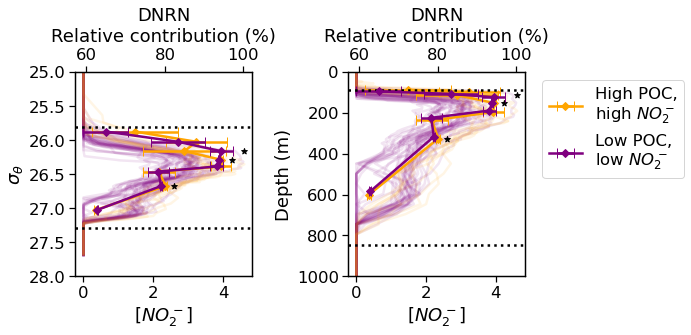

In [34]:
param = "DNRN"
delta = 0.03

slopeslow = pd.read_excel(f"output/chunk{chunklow}/slopesDF.xlsx")
slopeshigh = pd.read_excel(f"output/chunk{chunkhigh}/slopesDF.xlsx")

pvals = np.ones(slopeslow.shape[0])
outputvals = np.ones((slopeslow.shape[0],4))

for layer in list(slopeslow.index):

    dflow = pd.read_csv(f"output/chunk{chunklow}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    dfhigh = pd.read_csv(f"output/chunk{chunkhigh}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    
    slope1 = dflow[param].mean()
    n1 = slopeslow.iloc[layer].n
    se1 = dflow[param].std() / np.sqrt(n1)
    k1 = 2
    
    slope2 = dfhigh[param].mean()
    n2 = slopeshigh.iloc[layer].n
    se2 = dfhigh[param].std() / np.sqrt(n2)
    k2 = 2
    
    # Test statistic
    t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
    
    # Degrees of freedom (Welch–Satterthwaite)
    numerator = (se1**2 + se2**2)**2
    denominator = (se1**4)/(n1 - k1) + (se2**4)/(n2 - k2)
    df = numerator / denominator
    
    # Two-tailed p-value
    p = 2 * (1 - t.cdf(abs(t_stat), df))
    
    pvals[layer] = p
    outputvals[layer,:] = np.array([slope1, dflow[param].std(), slope2, dfhigh[param].std()])
    
    print(f"t = {t_stat:.3f}, df = {df:.1f}, p = {p:.4f}")

idx_sig = np.where(pvals <= 0.001)

fig, axes = plt.subplots(1,2, figsize = (10,5))

ax = axes[0]
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "purple", label = None, alpha = 0.1, zorder = 0)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "orange", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([28,25])
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()

ax2.errorbar(outputvals[:,2]*100, slopeshigh.sigma0,
            xerr = outputvals[:,3]*100, label = "High POC,\nhigh $NO_2^-$", color = "orange",
           marker = "D", capsize = 5, zorder = 1)

ax2.errorbar(outputvals[:,0]*100, slopeslow.sigma0,
            xerr = outputvals[:,1]*100, label = "Low POC,\nlow $NO_2^-$", color = "purple",
           marker = "D", capsize = 5, zorder = 2)

ax2.scatter(outputvals[idx_sig,0]*100 + outputvals[idx_sig,1]*100 + delta*100,
            slopeshigh.sigma0.iloc[idx_sig], marker = "*", color = "k")

#ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([28,25])

ax2.axhline(upperinterfacesigma, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacesigma, color = "k", linestyle = ":")
ax2.set_title(f"{param}\nRelative contribution (%)")

ax = axes[1]
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "purple", label = None, alpha = 0.1, zorder = 0)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "orange", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([1000,0])
ax.set_ylabel(r"Depth (m)")
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()
ax2.errorbar(outputvals[:,2]*100, slopeshigh.depth,
            xerr = outputvals[:,3]*100, label = "High POC,\nhigh $NO_2^-$", color = "orange",
           marker = "D", capsize = 5, zorder = 1)
ax2.errorbar(outputvals[:,0]*100, slopeslow.depth,
            xerr = outputvals[:,1]*100, label = "Low POC,\nlow $NO_2^-$", color = "purple",
           marker = "D", capsize = 5, zorder = 2)
ax2.scatter(outputvals[idx_sig,0]*100 + outputvals[idx_sig,1]*100 + delta*100,
            slopeshigh.depth.iloc[idx_sig], marker = "*", color = "k")

ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([1000,0])

ax2.axhline(upperinterfacedepth, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacedepth, color = "k", linestyle = ":")
ax2.set_title(f"{param}\nRelative contribution (%)")

plt.tight_layout()
plt.savefig("figures/DNRNprofiles.pdf", bbox_inches = "tight")

t = -6.092, df = 12.5, p = 0.0000
t = -2.297, df = 17.8, p = 0.0340
t = 3.601, df = 21.4, p = 0.0016
t = -1.595, df = 36.4, p = 0.1194
t = 12.691, df = 36.0, p = 0.0000
t = 3.890, df = 33.7, p = 0.0004
t = nan, df = nan, p = nan
t = nan, df = nan, p = nan


/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/2532645067.py:26: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/2532645067.py:31: RuntimeWarning: invalid value encountered in scalar divide
  df = numerator / denominator
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/2532645067.py:26: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/2532645067.py:31: RuntimeWarning: invalid value encountered in scalar divide
  df = numerator / denominator


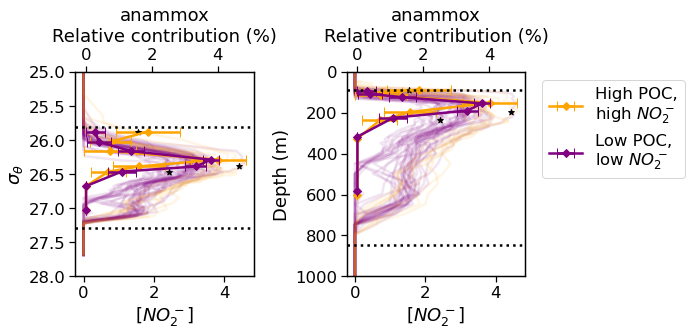

In [59]:
param = "anammox"
delta = 0.01

slopeslow = pd.read_excel(f"output/chunk{chunklow}/slopesDF.xlsx")
slopeshigh = pd.read_excel(f"output/chunk{chunkhigh}/slopesDF.xlsx")

pvals = np.ones(slopeslow.shape[0])
outputvals = np.ones((slopeslow.shape[0],4))

for layer in list(slopeslow.index):

    dflow = pd.read_csv(f"output/chunk{chunklow}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    dfhigh = pd.read_csv(f"output/chunk{chunkhigh}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    
    slope1 = dflow[param].mean()
    n1 = slopeslow.iloc[layer].n
    se1 = dflow[param].std() / np.sqrt(n1)
    k1 = 2
    
    slope2 = dfhigh[param].mean()
    n2 = slopeshigh.iloc[layer].n
    se2 = dfhigh[param].std() / np.sqrt(n2)
    k2 = 2
    
    # Test statistic
    t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
    
    # Degrees of freedom (Welch–Satterthwaite)
    numerator = (se1**2 + se2**2)**2
    denominator = (se1**4)/(n1 - k1) + (se2**4)/(n2 - k2)
    df = numerator / denominator
    
    # Two-tailed p-value
    p = 2 * (1 - t.cdf(abs(t_stat), df))
    
    pvals[layer] = p
    outputvals[layer,:] = np.array([slope1, dflow[param].std(), slope2, dfhigh[param].std()])
    
    print(f"t = {t_stat:.3f}, df = {df:.1f}, p = {p:.4f}")

idx_sig = np.where(pvals <= 0.001)

fig, axes = plt.subplots(1,2, figsize = (10,5))

ax = axes[0]
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "purple", label = None, alpha = 0.1, zorder = 0)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "orange", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([28,25])
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()

ax2.errorbar(outputvals[:,2]*100, slopeshigh.sigma0,
            xerr = outputvals[:,3]*100, label = "High POC,\nhigh $NO_2^-$", color = "orange",
           marker = "D", capsize = 5, zorder = 1)
ax2.errorbar(outputvals[:,0]*100, slopeslow.sigma0,
            xerr = outputvals[:,1]*100, label = "Low POC,\nlow $NO_2^-$", color = "purple",
           marker = "D", capsize = 5, zorder = 2)
ax2.scatter(outputvals[idx_sig,0]*100 + outputvals[idx_sig,1]*100 + delta*100,
            slopeshigh.sigma0.iloc[idx_sig], marker = "*", color = "k")

#ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([28,25])

ax2.axhline(upperinterfacesigma, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacesigma, color = "k", linestyle = ":")
ax2.set_title(f"{param}\nRelative contribution (%)")

ax = axes[1]
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "purple", label = None, alpha = 0.1, zorder = 0)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "orange", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([1000,0])
ax.set_ylabel(r"Depth (m)")
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()

ax2.errorbar(outputvals[:,2]*100, slopeshigh.depth,
            xerr = outputvals[:,3]*100, label = "High POC,\nhigh $NO_2^-$", color = "orange",
           marker = "D", capsize = 5, zorder = 1)
ax2.errorbar(outputvals[:,0]*100, slopeslow.depth,
            xerr = outputvals[:,1]*100, label = "Low POC,\nlow $NO_2^-$", color = "purple",
           marker = "D", capsize = 5, zorder = 2)
ax2.scatter(outputvals[idx_sig,0]*100 + outputvals[idx_sig,1]*100 + delta*100,
            slopeshigh.depth.iloc[idx_sig], marker = "*", color = "k")

ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([1000,0])

ax2.axhline(upperinterfacedepth, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacedepth, color = "k", linestyle = ":")
ax2.set_title(f"{param}\nRelative contribution (%)")

plt.tight_layout()
plt.savefig(f"figures/{param}profiles.pdf", bbox_inches = "tight")

t = 0.542, df = 12.7, p = 0.5973
t = 2.541, df = 24.1, p = 0.0179
t = -1.841, df = 20.3, p = 0.0804
t = nan, df = nan, p = nan
t = -0.127, df = 42.5, p = 0.8992
t = 9.964, df = 37.8, p = 0.0000
t = nan, df = nan, p = nan
t = nan, df = nan, p = nan


/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/4063416068.py:26: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/4063416068.py:31: RuntimeWarning: invalid value encountered in scalar divide
  df = numerator / denominator
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/4063416068.py:26: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/4063416068.py:31: RuntimeWarning: invalid value encountered in scalar divide
  df = numerator / denominator
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/4063416068.py:26: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/4

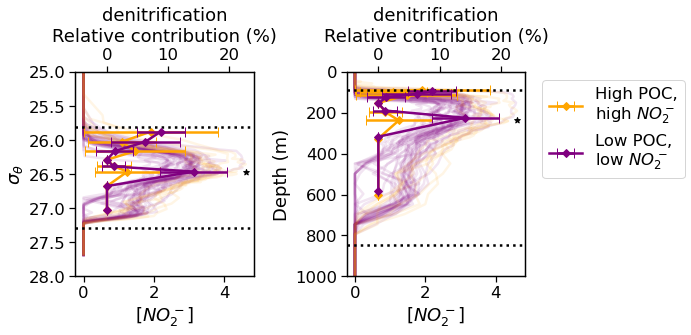

In [61]:
param = "denitrification"
delta = 0.03

slopeslow = pd.read_excel(f"output/chunk{chunklow}/slopesDF.xlsx")
slopeshigh = pd.read_excel(f"output/chunk{chunkhigh}/slopesDF.xlsx")

pvals2 = np.ones(slopeslow.shape[0])
outputvals = np.ones((slopeslow.shape[0],4))

for layer in list(slopeslow.index):

    dflow = pd.read_csv(f"output/chunk{chunklow}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    dfhigh = pd.read_csv(f"output/chunk{chunkhigh}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    
    slope1 = dflow[param].mean()
    n1 = slopeslow.iloc[layer].n
    se1 = dflow[param].std() / np.sqrt(n1)
    k1 = 2
    
    slope2 = dfhigh[param].mean()
    n2 = slopeshigh.iloc[layer].n
    se2 = dfhigh[param].std() / np.sqrt(n2)
    k2 = 2
    
    # Test statistic
    t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
    
    # Degrees of freedom (Welch–Satterthwaite)
    numerator = (se1**2 + se2**2)**2
    denominator = (se1**4)/(n1 - k1) + (se2**4)/(n2 - k2)
    df = numerator / denominator
    
    # Two-tailed p-value
    p = 2 * (1 - t.cdf(abs(t_stat), df))
    
    pvals2[layer] = p
    outputvals[layer,:] = np.array([slope1, dflow[param].std(), slope2, dfhigh[param].std()])
    
    print(f"t = {t_stat:.3f}, df = {df:.1f}, p = {p:.4f}")

idx_sig2 = np.where(pvals2 <= 0.001)

fig, axes = plt.subplots(1,2, figsize = (10,5))

ax = axes[0]
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "purple", label = None, alpha = 0.1, zorder = 0)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "orange", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([28,25])
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()

ax2.errorbar(outputvals[:,2]*100, slopeshigh.sigma0,
            xerr = outputvals[:,3]*100, label = "High POC,\nhigh $NO_2^-$", color = "orange",
           marker = "D", capsize = 5, zorder = 1)
ax2.errorbar(outputvals[:,0]*100, slopeslow.sigma0,
            xerr = outputvals[:,1]*100, label = "Low POC,\nlow $NO_2^-$", color = "purple",
           marker = "D", capsize = 5, zorder = 2)
ax2.scatter(outputvals[idx_sig2,0]*100 + outputvals[idx_sig2,1]*100 + delta*100,
            slopeshigh.sigma0.iloc[idx_sig2], marker = "*", color = "k")

#ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([28,25])

ax2.axhline(upperinterfacesigma, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacesigma, color = "k", linestyle = ":")
ax2.set_title(f"{param}\nRelative contribution (%)")

ax = axes[1]
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "purple", label = None, alpha = 0.1, zorder = 0)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "orange", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([1000,0])
ax.set_ylabel(r"Depth (m)")
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()

ax2.errorbar(outputvals[:,2]*100, slopeshigh.depth,
            xerr = outputvals[:,3]*100, label = "High POC,\nhigh $NO_2^-$", color = "orange",
           marker = "D", capsize = 5, zorder = 1)
ax2.errorbar(outputvals[:,0]*100, slopeslow.depth,
            xerr = outputvals[:,1]*100, label = "Low POC,\nlow $NO_2^-$", color = "purple",
           marker = "D", capsize = 5, zorder = 2)
ax2.scatter(outputvals[idx_sig2,0]*100 + outputvals[idx_sig2,1]*100 + delta*100,
            slopeshigh.depth.iloc[idx_sig2], marker = "*", color = "k")

ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([1000,0])

ax2.axhline(upperinterfacedepth, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacedepth, color = "k", linestyle = ":")
ax2.set_title(f"{param}\nRelative contribution (%)")

plt.tight_layout()
plt.savefig(f"figures/{param}profiles.pdf", bbox_inches = "tight")

t = 6.100, df = 13.1, p = 0.0000
t = 5.271, df = 18.8, p = 0.0000
t = 5.205, df = 19.7, p = 0.0000
t = 12.176, df = 35.9, p = 0.0000
t = -5.123, df = 35.4, p = 0.0000
t = -7.212, df = 29.1, p = 0.0000
t = -24.421, df = 119.8, p = 0.0000
t = 2.941, df = 47.5, p = 0.0050


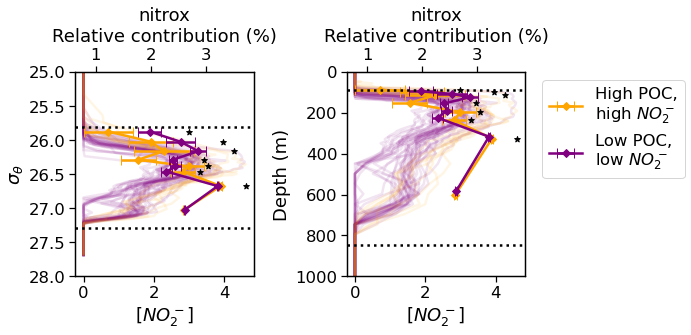

In [62]:
param = "nitrox"
delta = 0.005

slopeslow = pd.read_excel(f"output/chunk{chunklow}/slopesDF.xlsx")
slopeshigh = pd.read_excel(f"output/chunk{chunkhigh}/slopesDF.xlsx")

pvals = np.ones(slopeslow.shape[0])
outputvals = np.ones((slopeslow.shape[0],4))

for layer in list(slopeslow.index):

    dflow = pd.read_csv(f"output/chunk{chunklow}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    dfhigh = pd.read_csv(f"output/chunk{chunkhigh}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    
    slope1 = dflow[param].mean()
    n1 = slopeslow.iloc[layer].n
    se1 = dflow[param].std() / np.sqrt(n1)
    k1 = 2
    
    slope2 = dfhigh[param].mean()
    n2 = slopeshigh.iloc[layer].n
    se2 = dfhigh[param].std() / np.sqrt(n2)
    k2 = 2
    
    # Test statistic
    t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
    
    # Degrees of freedom (Welch–Satterthwaite)
    numerator = (se1**2 + se2**2)**2
    denominator = (se1**4)/(n1 - k1) + (se2**4)/(n2 - k2)
    df = numerator / denominator
    
    # Two-tailed p-value
    p = 2 * (1 - t.cdf(abs(t_stat), df))
    
    pvals[layer] = p
    outputvals[layer,:] = np.array([slope1, dflow[param].std(), slope2, dfhigh[param].std()])
    
    print(f"t = {t_stat:.3f}, df = {df:.1f}, p = {p:.4f}")

idx_sig = np.where(pvals <= 0.001)

fig, axes = plt.subplots(1,2, figsize = (10,5))

ax = axes[0]
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "purple", label = None, alpha = 0.1, zorder = 0)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "orange", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([28,25])
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()

ax2.errorbar(outputvals[:,2]*100, slopeshigh.sigma0,
            xerr = outputvals[:,3]*100, label = "High POC,\nhigh $NO_2^-$", color = "orange",
           marker = "D", capsize = 5, zorder = 1)
ax2.errorbar(outputvals[:,0]*100, slopeslow.sigma0,
            xerr = outputvals[:,1]*100, label = "Low POC,\nlow $NO_2^-$", color = "purple",
           marker = "D", capsize = 5, zorder = 2)
ax2.scatter(outputvals[idx_sig,0]*100 + outputvals[idx_sig,1]*100 + delta*100,
            slopeshigh.sigma0.iloc[idx_sig], marker = "*", color = "k")

#ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([28,25])

ax2.axhline(upperinterfacesigma, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacesigma, color = "k", linestyle = ":")
ax2.set_title(f"{param}\nRelative contribution (%)")

ax = axes[1]
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "purple", label = None, alpha = 0.1, zorder = 0)

for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("Depth")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.Depth),
                color = "orange", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([1000,0])
ax.set_ylabel(r"Depth (m)")
ax.set_xlabel(r"[$NO_2^-$]")

ax2 = ax.twiny()
ax2.errorbar(outputvals[:,2]*100, slopeshigh.depth,
            xerr = outputvals[:,3]*100, label = "High POC,\nhigh $NO_2^-$", color = "orange",
           marker = "D", capsize = 5, zorder = 1)
ax2.errorbar(outputvals[:,0]*100, slopeslow.depth,
            xerr = outputvals[:,1]*100, label = "Low POC,\nlow $NO_2^-$", color = "purple",
           marker = "D", capsize = 5, zorder = 2)
ax2.scatter(outputvals[idx_sig,0]*100 + outputvals[idx_sig,1]*100 + delta*100,
            slopeshigh.depth.iloc[idx_sig], marker = "*", color = "k")

ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([1000,0])

ax2.axhline(upperinterfacedepth, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacedepth, color = "k", linestyle = ":")
ax2.set_title(f"{param}\nRelative contribution (%)")

plt.tight_layout()
plt.savefig(f"figures/{param}profiles.pdf", bbox_inches = "tight")

t = -8.107, df = 12.0, p = 0.0000
t = -4.297, df = 15.0, p = 0.0006
t = 0.152, df = 19.2, p = 0.8809
t = 192.395, df = 145.0, p = 0.0000
t = 6.924, df = 33.5, p = 0.0000
t = -12.846, df = 27.1, p = 0.0000
t = nan, df = nan, p = nan
t = nan, df = nan, p = nan
t = -1.795, df = 12.2, p = 0.0975
t = -1.260, df = 15.4, p = 0.2264
t = -2.166, df = 19.4, p = 0.0430
t = 29.113, df = 35.0, p = 0.0000
t = 0.994, df = 38.5, p = 0.3267
t = -2.651, df = 27.5, p = 0.0132
t = nan, df = nan, p = nan
t = nan, df = nan, p = nan


/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/550472159.py:29: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/550472159.py:34: RuntimeWarning: invalid value encountered in scalar divide
  df = numerator / denominator
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/550472159.py:29: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/550472159.py:34: RuntimeWarning: invalid value encountered in scalar divide
  df = numerator / denominator
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/550472159.py:94: RuntimeWarning: invalid value encountered in scalar divide
  t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
/var/folders/gd/mzwd8ycd1q5d_pmld48bt7c80000gn/T/ipykernel_3263/550472

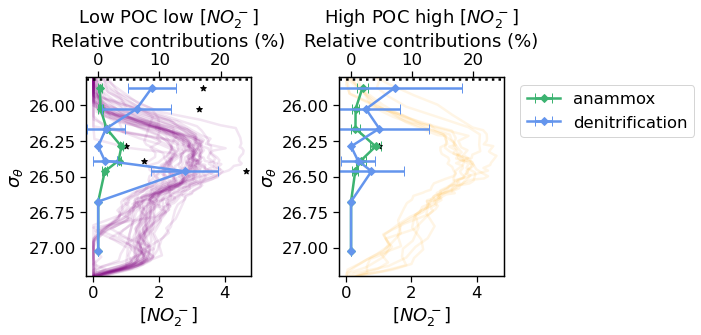

In [63]:
param1 = "anammox"
param2 = "denitrification"
delta = 0.045

fig, axes = plt.subplots(1,2, figsize = (10,5))

slopeslow = pd.read_excel(f"output/chunk{chunklow}/slopesDF.xlsx")
slopeshigh = pd.read_excel(f"output/chunk{chunkhigh}/slopesDF.xlsx")

pvals = np.ones(slopeslow.shape[0])
outputvals = np.ones((slopeslow.shape[0],4))

for layer in list(slopeslow.index):

    dflow = pd.read_csv(f"output/chunk{chunklow}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    dfhigh = pd.read_csv(f"output/chunk{chunkhigh}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    
    slope1 = dflow[param1].mean()
    n1 = slopeslow.iloc[layer].n
    se1 = dflow[param1].std() / np.sqrt(n1)
    k1 = 2
    
    slope2 = dflow[param2].mean()
    n2 = slopeshigh.iloc[layer].n
    se2 = dflow[param2].std() / np.sqrt(n2)
    k2 = 2
    
    # Test statistic
    t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
    
    # Degrees of freedom (Welch–Satterthwaite)
    numerator = (se1**2 + se2**2)**2
    denominator = (se1**4)/(n1 - k1) + (se2**4)/(n2 - k2)
    df = numerator / denominator
    
    # Two-tailed p-value
    p = 2 * (1 - t.cdf(abs(t_stat), df))
    
    pvals[layer] = p
    outputvals[layer,:] = np.array([slope1, dflow[param1].std(), slope2, dflow[param2].std()])
    
    print(f"t = {t_stat:.3f}, df = {df:.1f}, p = {p:.4f}")

idx_sig = np.where(pvals <= 0.001)

ax = axes[0]
for s in stationlistlow:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "purple", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([28,25])
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel(r"[$NO_2^-$]")
ax.set_title("Low POC low [$NO_2^-$]\nRelative contributions (%)")

ax2 = ax.twiny()
ax2.errorbar(outputvals[:,0]*100, slopeslow.sigma0,
            xerr = outputvals[:,1]*100, label = param1, color = "mediumseagreen",
           marker = "D", capsize = 5, zorder = 1)
ax2.errorbar(outputvals[:,2]*100, slopeshigh.sigma0,
            xerr = outputvals[:,3]*100, label = param2, color = "cornflowerblue",
           marker = "D", capsize = 5, zorder = 2)

ax2.scatter(outputvals[idx_sig,2]*100 + outputvals[idx_sig,3]*100 + delta*100,
            slopeshigh.sigma0.iloc[idx_sig], marker = "*", color = "k")

#ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([27.2,25.8])
ax2.set_xlim([-0.02*100, 0.25*100])

ax2.axhline(upperinterfacesigma, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacesigma, color = "k", linestyle = ":")

pvals = np.ones(slopeslow.shape[0])
outputvals = np.ones((slopeslow.shape[0],4))

for layer in list(slopeshigh.index):

    dfhigh = pd.read_csv(f"output/chunk{chunkhigh}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
    
    slope1 = dfhigh[param1].mean()
    n1 = slopeshigh.iloc[layer].n
    se1 = dfhigh[param1].std() / np.sqrt(n1)
    k1 = 2
    
    slope2 = dfhigh[param2].mean()
    n2 = slopeshigh.iloc[layer].n
    se2 = dfhigh[param2].std() / np.sqrt(n2)
    k2 = 2
    
    # Test statistic
    t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)
    
    # Degrees of freedom (Welch–Satterthwaite)
    numerator = (se1**2 + se2**2)**2
    denominator = (se1**4)/(n1 - k1) + (se2**4)/(n2 - k2)
    df = numerator / denominator
    
    # Two-tailed p-value
    p = 2 * (1 - t.cdf(abs(t_stat), df))
    
    pvals[layer] = p
    outputvals[layer,:] = np.array([slope1, dfhigh[param1].std(), slope2, dfhigh[param2].std()])
    
    print(f"t = {t_stat:.3f}, df = {df:.1f}, p = {p:.4f}")

idx_sig = np.where(pvals <= 0.001)

ax = axes[1]
for s in stationlisthigh:
    stationdata = data[data.Station == s].sort_values("sigma0")
    if len(stationdata) > 0:
        ax.plot(np.array(stationdata.NO2), np.array(stationdata.sigma0),
                color = "orange", label = None, alpha = 0.1, zorder = 0)

ax.set_ylim([28,25])
ax.set_ylabel(r"$\sigma_{\theta}$")
ax.set_xlabel(r"[$NO_2^-$]")
ax.set_title("High POC high [$NO_2^-$]\nRelative contributions (%)")

ax2 = ax.twiny()
ax2.errorbar(outputvals[:,0]*100, slopeslow.sigma0,
            xerr = outputvals[:,1]*100, label = param1, color = "mediumseagreen",
           marker = "D", capsize = 5, zorder = 1)
ax2.errorbar(outputvals[:,2]*100, slopeshigh.sigma0,
            xerr = outputvals[:,3]*100, label = param2, color = "cornflowerblue",
           marker = "D", capsize = 5, zorder = 2)
ax2.scatter(outputvals[idx_sig,2]*100 + outputvals[idx_sig,3]*100 + delta*100,
            slopeshigh.sigma0.iloc[idx_sig], marker = "*", color = "k")

ax2.legend(bbox_to_anchor = (1.05, 1.0), loc = "upper left")
ax2.set_ylim([27.2,25.8])
ax2.set_xlim([-0.02*100, 0.25*100])

ax2.axhline(upperinterfacesigma, color = "k", linestyle = ":")
ax2.axhline(lowerinterfacesigma, color = "k", linestyle = ":")

plt.tight_layout()
plt.savefig(f"figures/anammoxdenitprofiles.pdf", bbox_inches = "tight")

In [352]:
idx_sig

(array([], dtype=int64),)

In [207]:
layer = 2

df1 = pd.read_csv(f"output/chunk{chunk1}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
df2 = pd.read_csv(f"output/chunk{chunk2}/layer{layer}_coeff_iter.csv").rename(columns = columndict)

slope1 = df1[param].mean()
n1 = slopeslow.iloc[layer].n
se1 = df1[param].std() / np.sqrt(n1)
k1 = 2

slope2 = df2[param].mean()
n2 = slopeshigh.iloc[layer].n
se2 = df2[param].std() / np.sqrt(n2)
k2 = 2

# Test statistic
t_stat = (slope1 - slope2) / np.sqrt(se1**2 + se2**2)

# Degrees of freedom (Welch–Satterthwaite)
numerator = (se1**2 + se2**2)**2
denominator = (se1**4)/(n1 - k1) + (se2**4)/(n2 - k2)
df = numerator / denominator

# Two-tailed p-value
p = 2 * (1 - t.cdf(abs(t_stat), df))

print(f"t = {t_stat:.3f}, df = {df:.1f}, p = {p:.4f}")

t = 5.365, df = 73.6, p = 0.0000


chunklownitrite layer 2 stdev = 0.03018205451898237
chunkhighnitrite layer 2 stdev = 0.06545210094601761


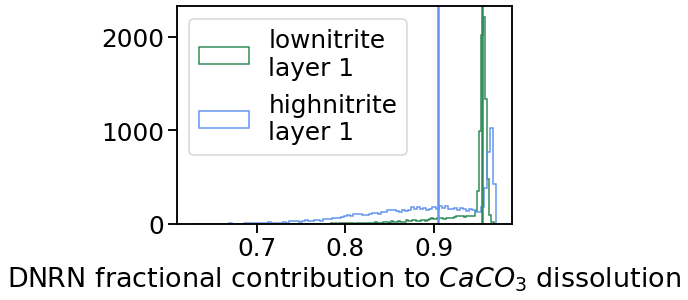

In [208]:
df1 = pd.read_csv(f"output/chunk{chunk1}/layer{layer}_coeff_iter.csv").rename(columns = columndict)
df2 = pd.read_csv(f"output/chunk{chunk2}/layer{layer}_coeff_iter.csv").rename(columns = columndict)

arr1 = np.array(df1[param])
arr2 = np.array(df2[param])

print(f"chunk{chunk1} layer {layer} stdev = {np.std(arr1)}")
print(f"chunk{chunk2} layer {layer} stdev = {np.std(arr2)}")

fig, ax = plt.subplots()
ax.hist(arr1, histtype = "step", bins = 100, label = label1, color = "seagreen")
ax.hist(arr2, histtype = "step", bins = 100, label = label2, color = "cornflowerblue")
ax.axvline(np.median(arr1), color = "seagreen")
ax.axvline(np.median(arr2), color = "cornflowerblue")
ax.set_xlabel(f"{param} fractional contribution to $CaCO_3$ dissolution")
ax.legend()

In [209]:
from scipy.stats import ttest_ind, ttest_ind_from_stats

# Compute the descriptive statistics of a and b.
abar = df1[param].mean()
astd = df1[param].std()
na = slopeslow.iloc[layer].n
adof = na - 1

bbar = df2[param].mean()
bstd = df2[param].std()
nb = slopeshigh.iloc[layer].n
bdof = nb - 1

# Use scipy.stats.ttest_ind_from_stats.
t2, p2 = ttest_ind_from_stats(mean1=abar, std1=astd, nobs1=na,
                              mean2=bbar, std2=bstd, nobs2=nb,
                              equal_var=False)
print("ttest_ind_from_stats: t = %g  p = %g" % (t2, p2))

ttest_ind_from_stats: t = 5.36465  p = 8.70421e-07


In [3]:
def testsignificance(ax, chunk1, chunk2, layer1, layer2, param,
                     dispxlabel=False, dispylabel=False, disptitle = False):
    
    columndict = {"# DNRN":"DNRN",
            " Anammox":"anammox",
            " Denitrification":"denitrification",
            " Nitrite Oxidation":"nitrox",
            " CaCO3 Dissolution ":"caco3diss"}
    
    df1 = pd.read_csv(f"output/chunk{chunk1}/layer{layer1}_coeff_iter.csv").rename(columns = columndict)
    df2 = pd.read_csv(f"output/chunk{chunk2}/layer{layer2}_coeff_iter.csv").rename(columns = columndict)
    
    arr1 = np.array(df1[param])
    arr2 = np.array(df2[param])
    
    print(f"chunk{chunk1} layer {layer1} variance = {np.var(arr1)}")
    print(f"chunk{chunk2} layer {layer2} variance = {np.var(arr2)}")

    ax.hist(arr1, histtype = "step", bins = 100, label = label1, color = "seagreen")
    ax.hist(arr2, histtype = "step", bins = 100, label = label2, color = "cornflowerblue")
    ax.axvline(np.median(arr1), color = "seagreen")
    ax.axvline(np.median(arr2), color = "cornflowerblue")

    if dispxlabel == True:
        ax.set_xlabel("Fractional contribution to $CaCO_3$ dissolution")
    if dispylabel == True:
        ax.set_ylabel("$n$")
    if disptitle == True:
        ax.set_title(param)
    ax.legend()
    
    ttestT, ttestp = stats.ttest_ind(arr1, arr2, equal_var=False)
    print(f"t test T = {ttestT}")
    print(f"t test p = {ttestp}")
    
    mannwhitneyU, mannwhitneyp = mannwhitneyu(arr1, arr2)
    print(f"Mann-Whitney U = {mannwhitneyU}")
    print(f"Mann-Whitney p = {mannwhitneyp}")
    
    return ttestT, ttestp, mannwhitneyU, mannwhitneyp

chunkhighnitrite layer 2 variance = 0.00015418664387786824
chunklownitrite layer 2 variance = 0.003077865738423329
t test T = -77.18943028959919
t test p = 0.0
Mann-Whitney U = 21834924.0
Mann-Whitney p = 0.0


(-77.18943028959919, 0.0, 21834924.0, 0.0)

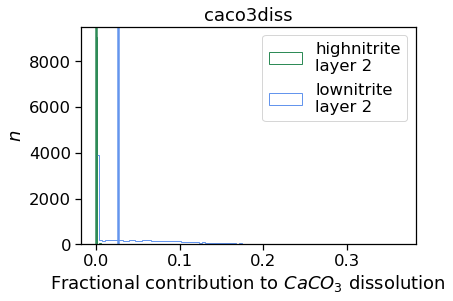

In [4]:
chunk1 = "highnitrite"
chunk2 = "lownitrite"
layer1 = 2
layer2 = 2
param = "caco3diss"
label1 = f"{chunk1}\nlayer {layer1}"
label2 = f"{chunk2}\nlayer {layer2}"

fig, ax  = plt.subplots()
testsignificance(ax, chunk1, chunk2, layer1, layer2, param,
                dispxlabel=True, dispylabel=True, disptitle = True)

In [55]:
layers = np.array([25.8, 26.1, 26.35, 26.5,27.2], dtype=float)  # in sigma0
divider = 2  # Number of sublayers in each layer
sl = np.zeros((len(layers) - 1, divider + 1))
for i in np.arange(0, len(layers) - 1):
    sl[i,] = np.linspace(layers[i], layers[i + 1], divider + 1)
sublayers = np.unique(sl)
ylabels = []
sublayers

array([25.8  , 25.95 , 26.1  , 26.225, 26.35 , 26.425, 26.5  , 26.85 ,
       27.2  ])

chunkhighnitrite layer 0 variance = 0.003752621831578692
chunklownitrite layer 0 variance = 0.002084077712458861
t test T = -76.48422045539516
t test p = 0.0
Mann-Whitney U = 22275385.0
Mann-Whitney p = 0.0
chunkhighnitrite layer 0 variance = 0.0019272958961608193
chunklownitrite layer 0 variance = 0.00013394825422288027
t test T = 153.90071671893995
t test p = 0.0
Mann-Whitney U = 90967982.5
Mann-Whitney p = 0.0
chunkhighnitrite layer 0 variance = 9.768052862399571e-06
chunklownitrite layer 0 variance = 5.319166469578434e-07
t test T = 81.63173360523305
t test p = 0.0
Mann-Whitney U = 74453473.0
Mann-Whitney p = 0.0
chunkhighnitrite layer 0 variance = 5.259886121913338e-06
chunklownitrite layer 0 variance = 2.7721129642905028e-06
t test T = -132.97469866667794
t test p = 0.0
Mann-Whitney U = 9201511.0
Mann-Whitney p = 0.0
chunkhighnitrite layer 0 variance = 0.004133450097631697
chunklownitrite layer 0 variance = 0.002241563161798031
t test T = -12.888881680355775
t test p = 7.58467242

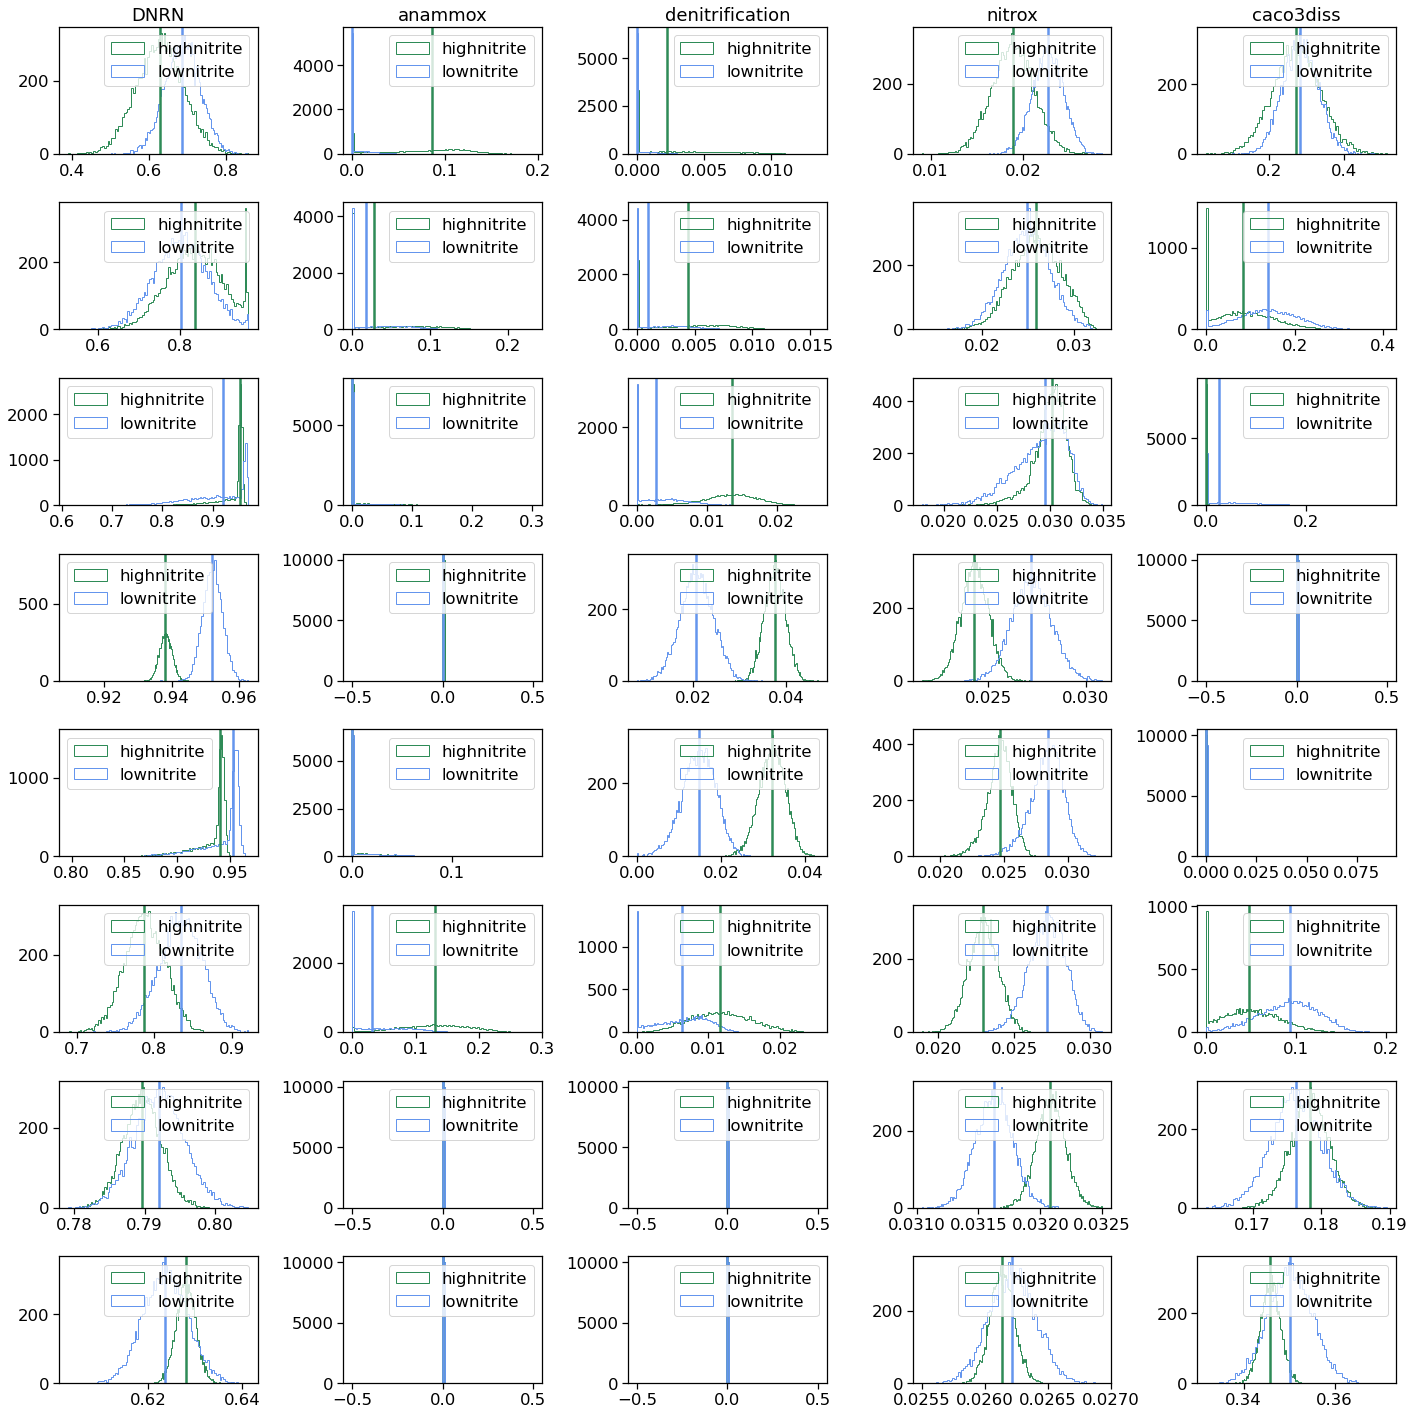

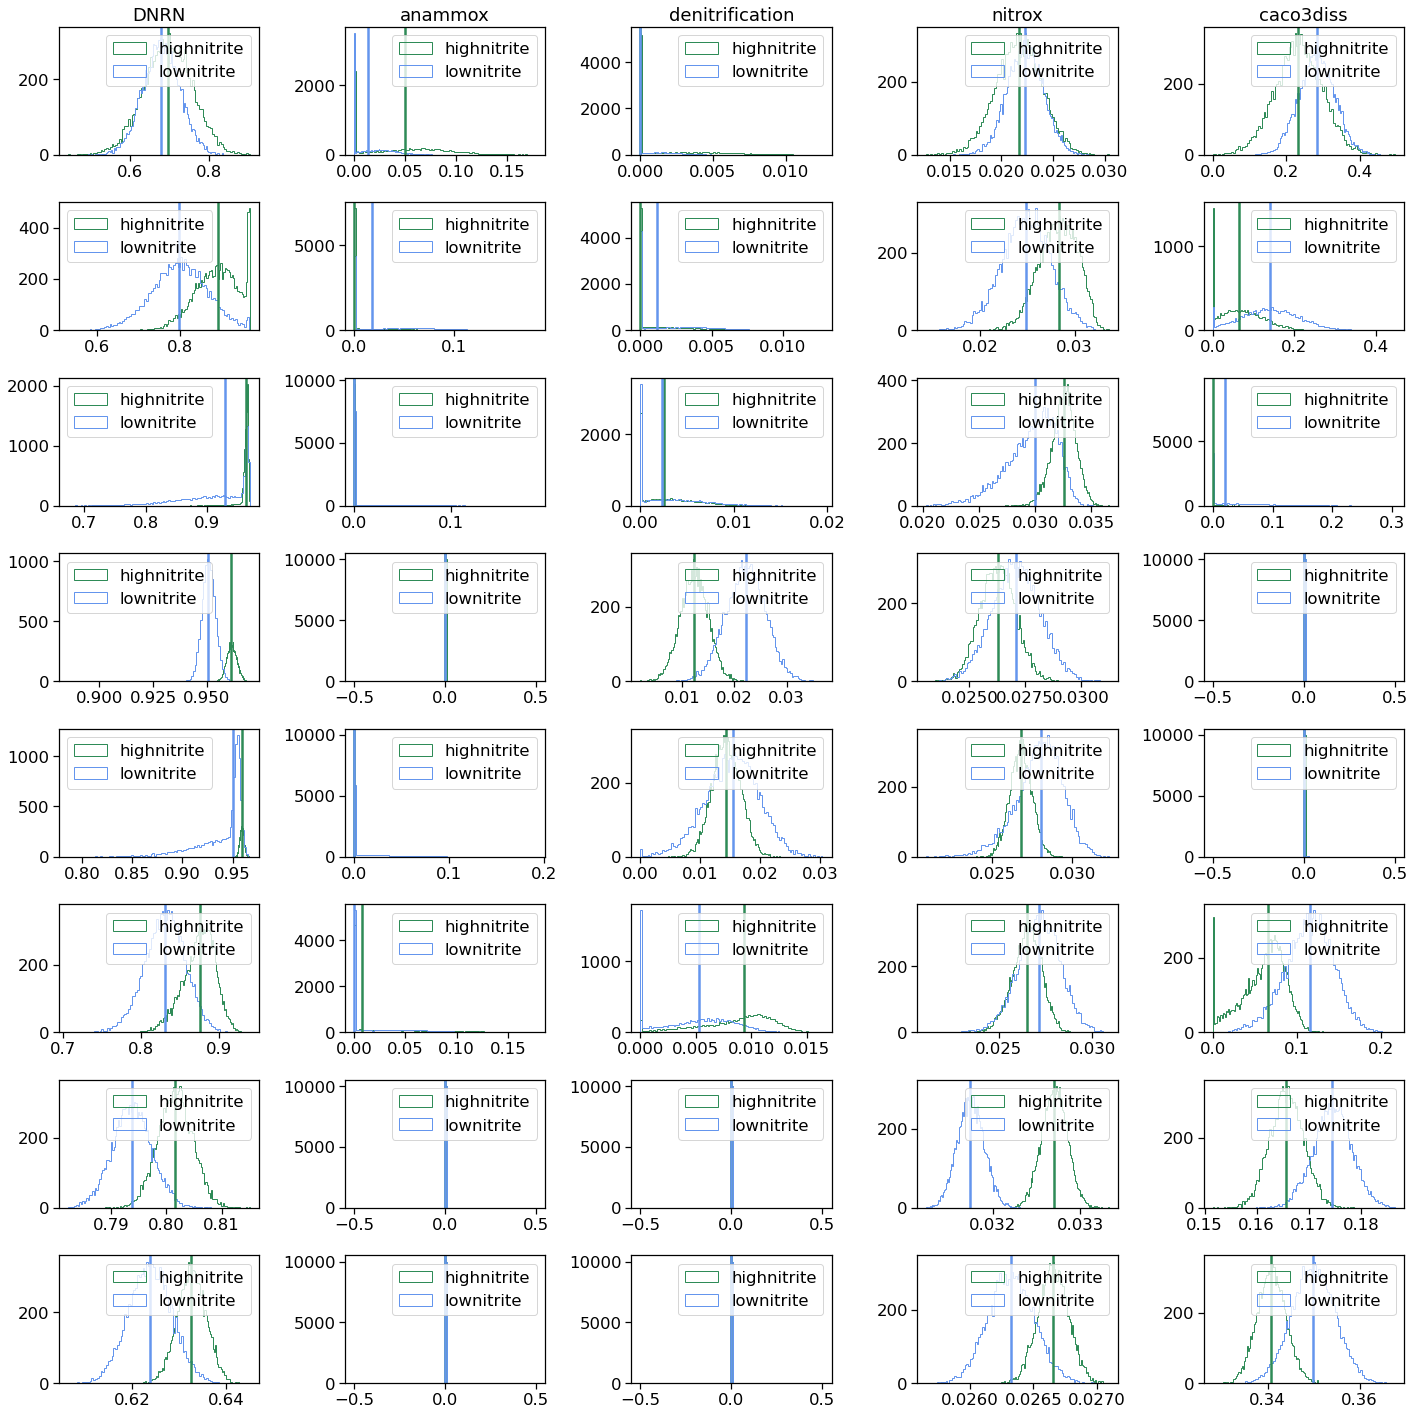

In [5]:
chunk1 = "highnitrite"
chunk2 = "lownitrite"
param = "caco3diss"
layers = np.array([25.8, 26.1, 26.35, 26.5,27.2], dtype=float)  # in sigma0
divider = 2  # Number of sublayers in each layer

params = ["DNRN","anammox","denitrification",
            "nitrox","caco3diss"]

layers = np.array([25.8, 26.1, 26.35, 26.5,27.2], dtype=float)  # in sigma0
divider = 2  # Number of sublayers in each layer
sl = np.zeros((len(layers) - 1, divider + 1))
for i in np.arange(0, len(layers) - 1):
    sl[i,] = np.linspace(layers[i], layers[i + 1], divider + 1)
sublayers = np.unique(sl)
ylabels = []

for i in range(len(sublayers)-1):
    label = fr"{sublayers[i]:.4} - {sublayers[i+1]:.4}"
    ylabels.append(label)
nlayers = len(ylabels)

ttestoutput = np.ones((nlayers,5))
mannwhitneyoutput = np.ones((nlayers,5))

fig, axes = plt.subplots(nlayers, len(params), figsize = (20,20))

for i in range(0,nlayers):
    layer1 = i
    layer2 = i
    label1 = f"{chunk1}"
    label2 = f"{chunk2}"
    
    for count, p in enumerate(params):
        ax = axes[i, count]
        if i==0:
            ttestT, ttestp, mannwhitneyU, mannwhitneyp = testsignificance(ax, chunk1, chunk2, layer1, layer2, p,
                                                                         disptitle = True)
        else:
            ttestT, ttestp, mannwhitneyU, mannwhitneyp = testsignificance(ax, chunk1, chunk2, layer1, layer2, p)
        ttestoutput[i, count] = ttestp
        mannwhitneyoutput[i, count] = mannwhitneyp
        
plt.tight_layout()
plt.savefig("stats/high vs low nitrite.pdf")

In [6]:
mannwhitneyoutput = pd.DataFrame(mannwhitneyoutput,
            columns = params)
mannwhitneyoutput["layer"] = ylabels
mannwhitneyoutput = mannwhitneyoutput.set_index("layer")
mannwhitneyoutput.to_excel("stats/Mann-Whitney test high vs low nitrite.xlsx")
mannwhitneyoutput

,DNRN,anammox,denitrification,nitrox,caco3diss
layer,,,,,
25.8 - 25.95,0.000000e+00,0.000000e+00,0.0,0.000000e+00,9.043796e-37
25.95 - 26.1,2.422304e-258,3.383052e-53,0.0,1.701936e-171,0.000000e+00
26.1 - 26.23,4.147159e-135,6.896050e-13,0.0,4.929338e-137,0.000000e+00
26.23 - 26.35,0.000000e+00,2.694777e-03,0.0,0.000000e+00,1.000000e+00
26.35 - 26.43,0.000000e+00,8.416748e-01,0.0,0.000000e+00,2.911871e-184
26.43 - 26.5,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
26.5 - 26.85,0.000000e+00,1.000000e+00,1.0,0.000000e+00,0.000000e+00
26.85 - 27.2,0.000000e+00,1.000000e+00,1.0,4.519306e-285,0.000000e+00


In [7]:
ttestoutput = pd.DataFrame(ttestoutput,
            columns = params)
ttestoutput["layer"] = ylabels
ttestoutput = ttestoutput.set_index("layer")
ttestoutput.to_excel("stats/T test high vs low nitrite.xlsx")
ttestoutput

,DNRN,anammox,denitrification,nitrox,caco3diss
layer,,,,,
25.8 - 25.95,0.000000e+00,0.000000e+00,0.0,0.000000e+00,7.584672e-38
25.95 - 26.1,5.234662e-276,1.477499e-115,0.0,6.449934e-178,0.000000e+00
26.1 - 26.23,0.000000e+00,7.359354e-03,0.0,1.743218e-210,0.000000e+00
26.23 - 26.35,0.000000e+00,2.012709e-02,0.0,0.000000e+00,NaN
26.35 - 26.43,8.886977e-291,4.329989e-12,0.0,0.000000e+00,1.249396e-108
26.43 - 26.5,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00
26.5 - 26.85,0.000000e+00,NaN,NaN,0.000000e+00,0.000000e+00
26.85 - 27.2,0.000000e+00,NaN,NaN,2.644107e-302,0.000000e+00


In [15]:
ylabels

['25.8 - 25.95',
 '25.95 - 26.1',
 '26.1 - 26.23',
 '26.23 - 26.35',
 '26.35 - 26.43',
 '26.43 - 26.5',
 '26.5 - 26.85',
 '26.85 - 27.2']

127390.99716126079 0.0
20276.231362527797 0.0
235645.99076100255 0.0
76949.04948934147 0.0
149602.83606613375 0.0
98317.53092607883 0.0
4190.535088692776 0.0
78396.81919280667 0.0
30377.21816142878 0.0
119016.33541495667 0.0


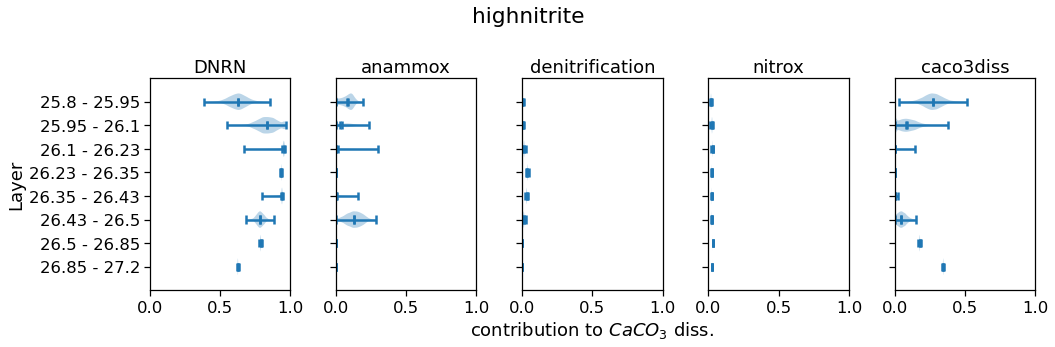

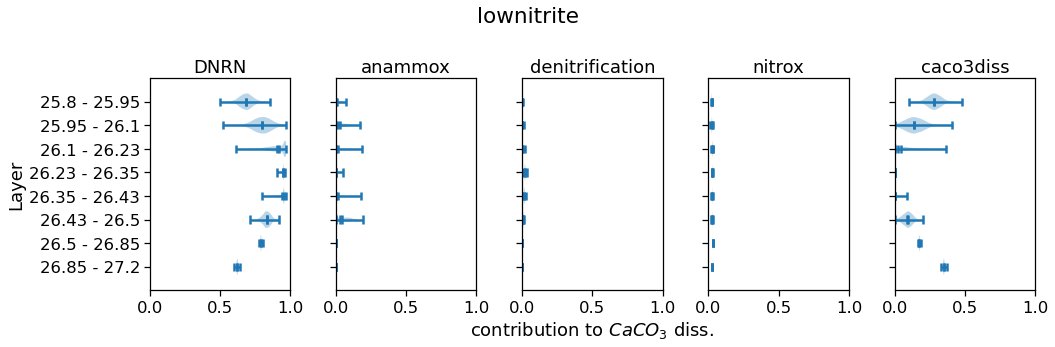

In [14]:
chunks = ["highnitrite", "lownitrite"]
params = ["DNRN","anammox","denitrification",
            "nitrox","caco3diss"]

ANOVAoutput = np.ones((len(chunks),len(params)))
columndict = {'# DNRN':"DNRN",
              ' Anammox':"anammox",
              ' Denitrification':"denitrification",
              ' Nitrite Oxidation':"nitrox",
              ' CaCO3 Dissolution ':"caco3diss"}

for i, chunk in enumerate(chunks):
    fig, axes = plt.subplots(1,5, figsize =(15,5), sharey=True)
    for count, param in enumerate(params):
        df0 = pd.read_csv(f"output/chunk{chunk}/layer0_coeff_iter.csv").rename(columns = columndict)
        df1 = pd.read_csv(f"output/chunk{chunk}/layer1_coeff_iter.csv").rename(columns = columndict)
        df2 = pd.read_csv(f"output/chunk{chunk}/layer2_coeff_iter.csv").rename(columns = columndict)
        df3 = pd.read_csv(f"output/chunk{chunk}/layer3_coeff_iter.csv").rename(columns = columndict)
        df4 = pd.read_csv(f"output/chunk{chunk}/layer4_coeff_iter.csv").rename(columns = columndict)
        df5 = pd.read_csv(f"output/chunk{chunk}/layer5_coeff_iter.csv").rename(columns = columndict)
        df6 = pd.read_csv(f"output/chunk{chunk}/layer6_coeff_iter.csv").rename(columns = columndict)
        df7 = pd.read_csv(f"output/chunk{chunk}/layer7_coeff_iter.csv").rename(columns = columndict)

        arr0 = np.array(df0[param])
        arr1 = np.array(df1[param])
        arr2 = np.array(df2[param])
        arr3 = np.array(df3[param])
        arr4 = np.array(df4[param])
        arr5 = np.array(df5[param])
        arr6 = np.array(df6[param])
        arr7 = np.array(df7[param])
        
        df = pd.DataFrame([arr0,arr1,arr2,arr3,arr4,arr5,arr6,arr7]).T
        df.rename(columns = dict(zip(list(range(0,8)),ylabels)))
        ax = axes[count]
        ax.violinplot(df, points=80, vert=False, widths=0.7,
                     showmeans=True, showextrema=True, showmedians=True)
        ax.set_ylim([9,0])
        ax.set_xlim([0,1.0])
        ax.set_yticks(list(range(1,9)))
        ax.set_yticklabels(ylabels)
        ax.set_title(param)
        if count==0:
            ax.set_ylabel("Layer")
        elif count==2:
            ax.set_xlabel("contribution to $CaCO_3$ diss.")

        F, p = stats.f_oneway(arr0,arr1,arr2,arr3,arr4,arr5,arr6,arr7)
        print(F,p)

        ANOVAoutput[i,count] = p
    fig.suptitle(f"{chunk}")
    plt.tight_layout()
    plt.savefig(f"stats/chunk{chunk} violinplot.pdf")

In [9]:
ANOVAoutput = pd.DataFrame(ANOVAoutput,
            columns = params)
ANOVAoutput["chunk"] = chunks
ANOVAoutput = ANOVAoutput.set_index("chunk")
ANOVAoutput.to_excel("stats/ANOVA.xlsx")
ANOVAoutput

,DNRN,anammox,denitrification,nitrox,caco3diss
chunk,,,,,
highnitrite,1.0,1.0,1.0,1.0,1.0
lownitrite,1.0,1.0,1.0,1.0,1.0
